# Creating Jupyter notebook widgets with interact/interactive
* (Done) Part 0: Install ipywidgets extension and use "interact" to generate user interface controls that can interact with data
* (Done) Part 1: Generate code for an interval slider
* (Done) Part 2: Dynamically pull the intervals from Derek's code (1% and 99%) into the range slider
* (Done) Part 3: Find where the plotting code updates based on input values and replace with a variable from the slider
* (Done) Part 4: Convert those percentiles to pixels and change the before and after tiles based on user interactions
* (Done) Part 5: Generate a membrane merge preview
* (Done) Part 6: Generate a final preview image with nuclear + membrane
* (Done) Part 7: Populate the for loop of sliding bars into their own respective tabs labeled by channel name

# Set user-defined parameters to tune input to Mesmer
* The first element of "cyclesToUse" and "channelsToUse" is assumed to be the nuclear channel (typically cycle 2, channel 1)
* The remaining elements are assumed to be membrane channels that one intends to merge into a "pan-membrane" channel for Mesmer
* Choose the name of the root directory for all "tiles" data output by Akoya Processor
* Choose the name of the tile within "inTileRootDir" to tune on with "inTile" -- e.g. reg001_X07_Y05


In [1]:
# User parameters to set
mcmicroDir = '/mnt/isilon/tan_lab_imaging/FUSION/NBM27_H10_CITRATE_REIMAGE/H10/Scan1/'
cyclesToUse   = [1, 3, 4, 11]
channelsToUse = [1, 1, 4, 3]
# select the window for visualization within the prep notebook
xTileSubset = 8
yTileSubset = 8

xTilePixel = 1920
yTilePixel = 1440
overlap = 0.3
nChannel = 4

useDefaultSettings = True
quantileDefaultLo = 0.001
quantileDefaultHi = 0.99

# Import necessary packages
* Interval Range Slider: https://panel.holoviz.org/reference/widgets/IntRangeSlider.html
* Linking Jupyter Notebook Widget outputs: https://coderzcolumn.com/tutorials/python/interactive-widgets-in-jupyter-notebook-using-ipywidgets
* Building more complex dashboards: https://ipython-books.github.io/33-mastering-widgets-in-the-jupyter-notebook/
* For loop into widget tabs: https://stackoverflow.com/questions/50842160/how-to-display-matplotlib-plots-in-a-jupyter-tab-widget


In [2]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import tifffile
import imageio
import glob
import re

# Import interactive widget library
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, fixed, VBox

/mnt/isilon/tan_lab/bandyopads/miniconda3/envs/Mesmer_0.10/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Custom function definitions

In [3]:
# Linearly input data with high and low saturation at "hi" and "lo" respectively
def saturateRescale(x, lo = 0, hi = 65535, max = 65535):
    x = np.where(x > hi, hi, x)
    x = np.where(x < lo, lo, x)
    r = hi - lo
    x = x - lo
    x = x / r
    x = x * max
    return np.round(x)

# Read and rescale TIF (read as numpy array "img") using a low/high range that is log2-transformed
def custom_range_image_log2(low_high_range, img):
    # Using across the entire .tif, do linear rescaling with nuclear quantile 0 and 1 which were computed automatically
    img_rescale = saturateRescale(img, 2**low_high_range[0], 2**low_high_range[1])

    fig = plt.figure(figsize=(15,15)) #set up figure configurations
    ax_orig = fig.add_subplot(121) #position for first plot
    ax_rescale = fig.add_subplot(122) #position for second plot

    ax_orig.imshow(img) #plot with original image data
    ax_rescale.imshow(img_rescale) #plot with rescaled image data
    
    ax_orig.set_title('Non Norm')
    ax_rescale.set_title('Norm')

def idx2DTo1D(cycle, channel):
    return (cycle - 1) * nChannel + (channel - 1)

In [4]:
inOmeTiff = glob.glob(mcmicroDir + '/*qptiff')[0]

outDir = os.path.join(mcmicroDir, 'mesmer')
if not os.path.exists(outDir):
    os.makedirs(outDir)
sampleName = os.path.basename(mcmicroDir)
outFile = os.path.join(outDir, sampleName + '_nuclear_panmembrane.ome.tif')

print('Input OME.TIFF file: ' + inOmeTiff)
print('Output OME.TIFF file: ' + outFile)

Input OME.TIFF file: /mnt/isilon/tan_lab_imaging/FUSION/NBM27_H10_CITRATE_REIMAGE/H10/Scan1/H10_Scan1.qptiff
Output OME.TIFF file: /mnt/isilon/tan_lab_imaging/FUSION/NBM27_H10_CITRATE_REIMAGE/H10/Scan1/mesmer/_nuclear_panmembrane.ome.tif


In [5]:
im = tifffile.imread(inOmeTiff)
print(im.shape)
im = np.array(im).astype(np.float32)
# im[18,:,:] = im[18,:,:] - im[2,:,:] # Subtract the 550 blank from Vimentin on 550 channel 
# im[18,:,:] = np.subtract(im[18,:,:], im[2,:,:]) # Subtract the 550 blank from Vimentin on 550 channel 
# im[23,:,:] = im[23,:,:] - im[3,:,:] # Subtract the Cy5 blank from CD45 on 550 channel
#im[23,:,:] = np.subtract(im[23,:,:], im[3,:,:]) # Subtract the Cy5 blank from CD45 on 550 channel 
#im[18,:,:] = np.clip(a=im[18,:,:], a_min=0, a_max=None) # Clip negative values to zero
#im[23,:,:] = np.clip(a=im[23,:,:], a_min=0, a_max=None) # Clip negative values to zero
print(im.shape)

(54, 24480, 16320)
(54, 24480, 16320)


In [6]:
# TEST im object
type(im[23,1,1])

numpy.float32

# Automatically detect cycle/channel number and read in selected TIFs

In [7]:
xTileCount = np.round((im.shape[2]) / (xTilePixel * (1-overlap)))
yTileCount = np.round((im.shape[1]) / (yTilePixel * (1-overlap)))
nCycle = im.shape[0] / nChannel

channelsToUse1D = []
for ii in range(len(cyclesToUse)):
    channelsToUse1D.append(idx2DTo1D(cyclesToUse[ii], channelsToUse[ii]))

xPixel = np.array((xTileSubset-1, xTileSubset)) * round(im.shape[2] / xTileCount) 
yPixel = np.array((yTileSubset-1, yTileSubset)) * round(im.shape[1] / yTileCount) 

print('Tile X Dimension: {:0.2f}'.format(xTileCount))
print('Tile X Dimension: {:0.2f}'.format(yTileCount))

Tile X Dimension: 12.00
Tile X Dimension: 24.00



# Load & tune rescaling values for Nuclear and Membrane TIFs
* vFuncSaturateRescale function will calculate the 1%ile and 99%ile for the specified .tif image and plot both the non-normalized original image vs. the rescaled values.
* The tuning bar allows a user to browse and rescale the "Norm" plot to update with new range values
* The cell needs to be rerun or manually reset by dragging the slider to return to the initial rescaling values
* You can also type into the box the range values you want

In [8]:
arr_list = []
for ii in range(len(cyclesToUse)):
    arr_list.append(im[channelsToUse1D[ii],yPixel[0]:yPixel[1],xPixel[0]:xPixel[1]])
    #arr_list.append(im[channelsToUse1D[ii],:,:])


In [9]:
sub_tab=[widgets.Output() for i in range(len(arr_list))]
tab = widgets.Tab(sub_tab)
tabs_list = ['Nuclear'] + ['Membrane_' + str(ii) for ii in range(1,len(channelsToUse))]

slider_list = []

for ii in range(len(arr_list)): #get range from list that holds membrane data
    tab.set_title(ii, tabs_list[ii])
    #print(ii)

    with sub_tab[ii]:
        quantile_default = np.log2(np.quantile(arr_list[ii], q = (quantileDefaultLo, quantileDefaultHi), axis=(0,1))) #calculate quantiles for each channel
        slider_list.append(widgets.FloatRangeSlider(
            value=[quantile_default[0], quantile_default[1]],
            min=0, 
            max=16, 
            step=0.1,
            readout_format='.1f',
            description='Log2 Mk ' + str(ii+1) + ':',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True
        ))
        interact(custom_range_image_log2, low_high_range = slider_list[ii], img = fixed(arr_list[ii]))
display(tab)

# Obtain low/high tuning parameters from slider bars above or by default settings

In [10]:
# if useDefaultSettings == False:
    # lo_quantile_list = [int(np.round(2**(slider_list[ii].value[0]))) for ii in range(len(slider_list))]
    # hi_quantile_list = [int(np.round(2**(slider_list[ii].value[1]))) for ii in range(len(slider_list))]

# Rewrote this to just always take the slider values, check the printed values to confirm this has worked
lo_quantile_list = [int(np.round(2**(slider_list[ii].value[0]))) for ii in range(len(slider_list))]
hi_quantile_list = [int(np.round(2**(slider_list[ii].value[1]))) for ii in range(len(slider_list))]

    
    
# if useDefaultSettings == True:   
    # lo_quantile_list = np.round([np.quantile(im[ii,:,:], q = quantileDefaultLo, axis=(0,1)) for ii in channelsToUse1D])
    # hi_quantile_list = np.round([np.quantile(im[ii,:,:], q = quantileDefaultHi, axis=(0,1)) for ii in channelsToUse1D])
  
print(lo_quantile_list)
print(hi_quantile_list)

# Manual Selection because slider value retrieval isn't working
# lo_quantile_list = np.round([0.,5792.6,512.])
# hi_quantile_list = np.round([65536.,23170.5,8192.])
# print(lo_quantile_list)
# print(hi_quantile_list)

[2, 2, 1, 1]
[32768, 239, 362, 274]


# Rescale nuclear data and plot result

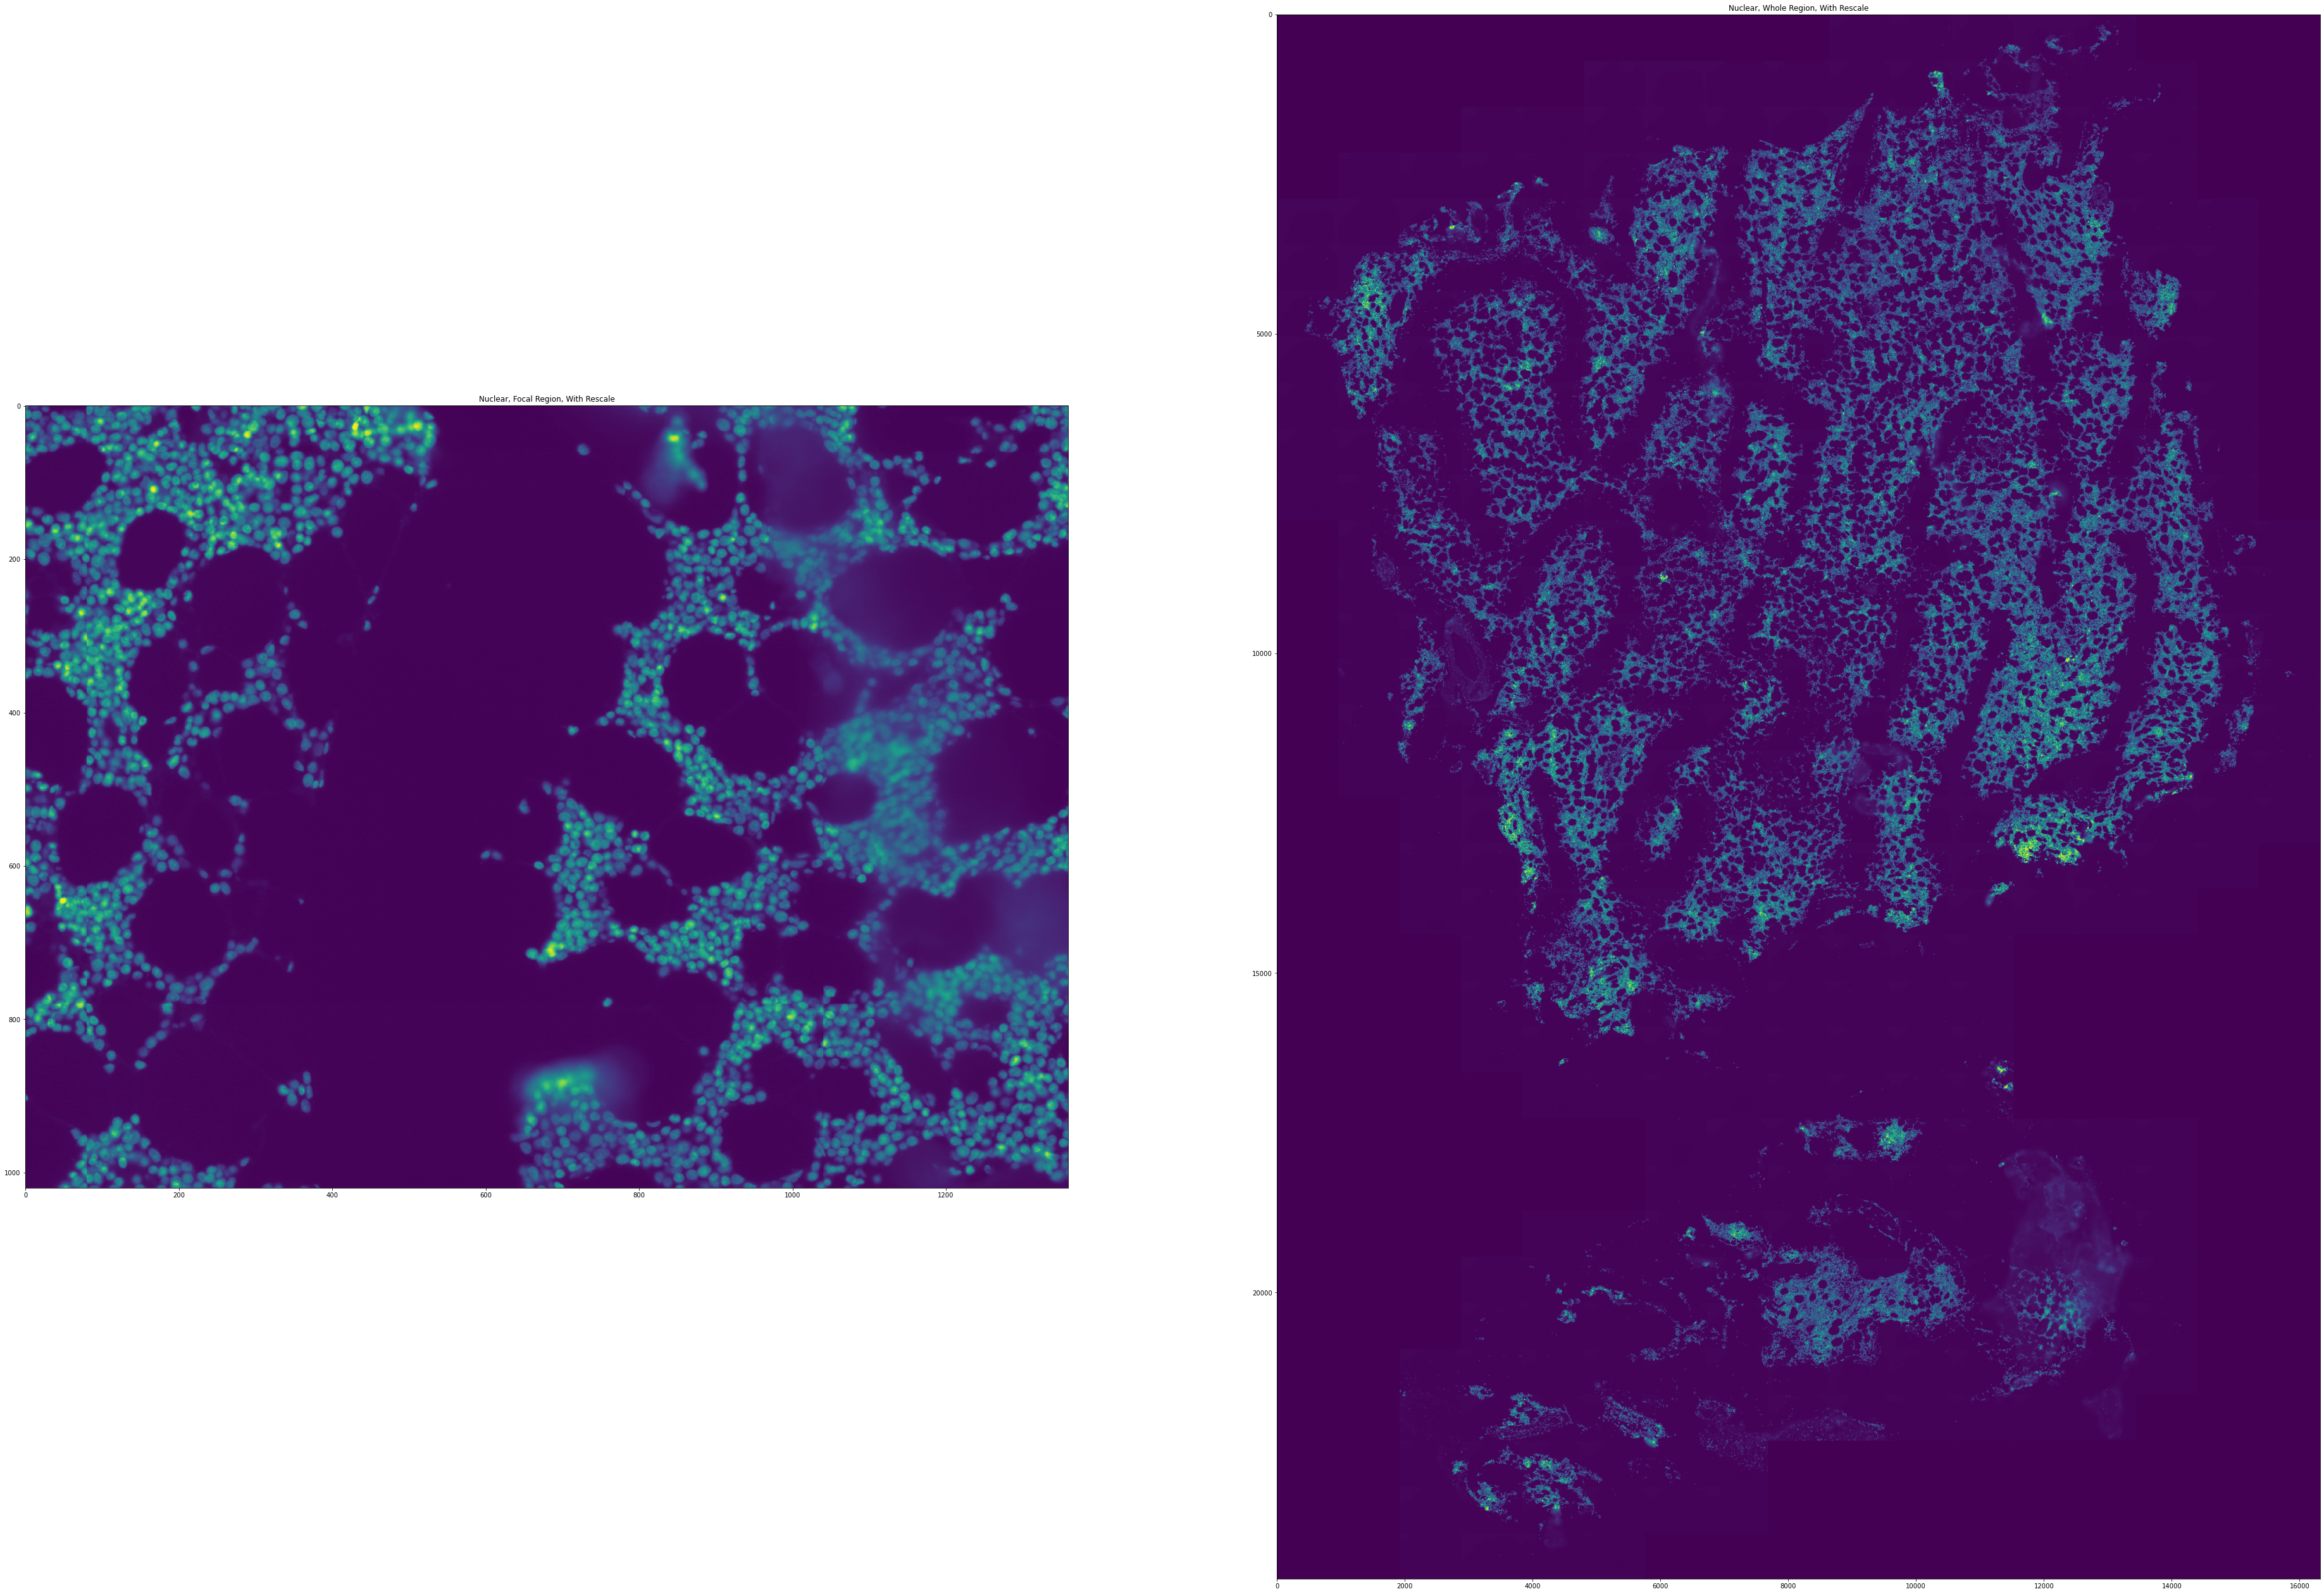

In [11]:
nuclearIdx = 0
nuclear_rescale = saturateRescale(x = arr_list[nuclearIdx], lo = lo_quantile_list[nuclearIdx], hi = hi_quantile_list[nuclearIdx])
nuclear_rescale_all = saturateRescale(x = im[channelsToUse1D[nuclearIdx],], lo = lo_quantile_list[nuclearIdx], hi = hi_quantile_list[nuclearIdx])

# Plot nuclear data with and without rescaling
fig, ax = plt.subplots(1, 2, figsize=(65, 65))
ax[0].imshow(nuclear_rescale)
ax[1].imshow(nuclear_rescale_all)

ax[0].set_title('Nuclear, Focal Region, With Rescale')
ax[1].set_title('Nuclear, Whole Region, With Rescale')

plt.show()

In [12]:
membrane_channels = arr_list[1:]
membrane_lo_quantile_list = lo_quantile_list[1:]
membrane_hi_quantile_list = hi_quantile_list[1:]

orig_tif_list = []
norm_tif_list = []
norm_tif_list_all = []

for ii, arr in enumerate(membrane_channels):
    orig_tif_list.append(arr)
    norm_tif_list.append(    saturateRescale(x=orig_tif_list[ii],          lo=membrane_lo_quantile_list[ii], hi=membrane_hi_quantile_list[ii]))
    norm_tif_list_all.append(saturateRescale(x=im[channelsToUse1D[ii+1],], lo=membrane_lo_quantile_list[ii], hi=membrane_hi_quantile_list[ii]))


# Rescale and merge all membrane data and plot result

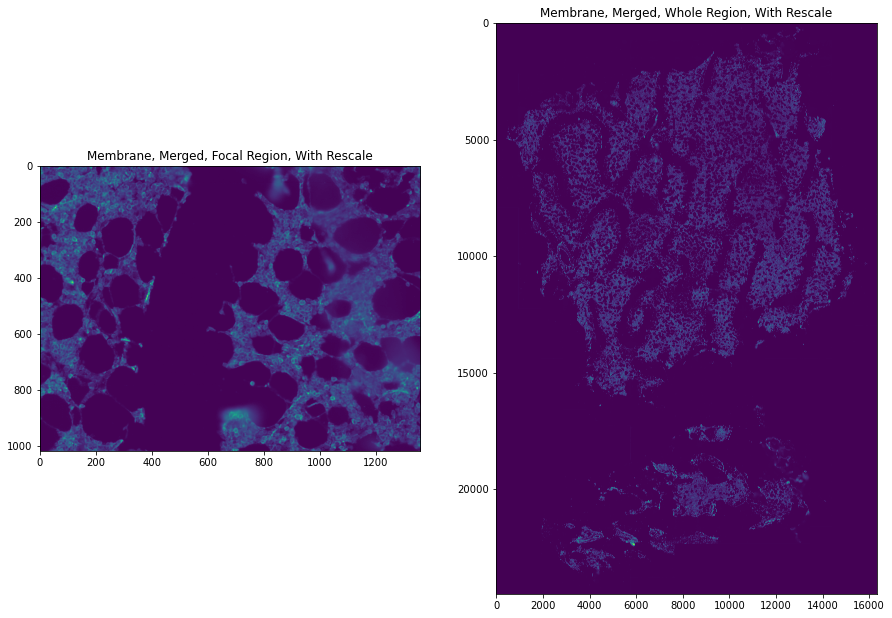

In [13]:
membrane_orig_merged = np.zeros(orig_tif_list[0].shape)
membrane_norm_merged = np.zeros(orig_tif_list[0].shape)
membrane_norm_all_merged = np.zeros(norm_tif_list_all[0].shape)

for ii, tif in enumerate(membrane_channels):
    #print(ii)
    membrane_orig_merged += orig_tif_list[ii]
    membrane_norm_merged += norm_tif_list[ii]
    membrane_norm_all_merged += norm_tif_list_all[ii]
membrane_orig_merged /= len(membrane_channels)
membrane_norm_merged /= len(membrane_channels) #add data from membrane channels & divide by length of list
membrane_norm_all_merged /= len(membrane_channels)

# Perform min/max rescaling
minMaxQuantile = np.quantile(membrane_norm_all_merged, q=(0, 1), axis=(0, 1))
#membrane_norm_merge_quantile     = np.quantile(membrane_norm_merged,     q=(0, 1), axis=(0, 1))
#membrane_orig_merge_quantile     = np.quantile(membrane_orig_merged,     q=(0, 1), axis=(0, 1))
#membrane_norm_all_merge_quantile = np.quantile(membrane_norm_all_merged, q=(0, 1), axis=(0, 1))
membrane_norm_merge_quantile     = minMaxQuantile
membrane_orig_merge_quantile     = minMaxQuantile
membrane_norm_all_merge_quantile = minMaxQuantile

membrane_norm_merged_rescale = saturateRescale(membrane_norm_merged, membrane_norm_merge_quantile[0],
                                                    membrane_norm_merge_quantile[1])

membrane_orig_merged_rescale = saturateRescale(membrane_orig_merged, membrane_orig_merge_quantile[0],
                                                    membrane_orig_merge_quantile[1])

membrane_norm_all_merged_rescale = saturateRescale(membrane_norm_all_merged, membrane_norm_all_merge_quantile[0],
                                                    membrane_norm_all_merge_quantile[1])


# Plot merged data with and without rescaling
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(membrane_norm_merged_rescale)
ax[1].imshow(membrane_norm_all_merged_rescale)

ax[0].set_title('Membrane, Merged, Focal Region, With Rescale')
ax[1].set_title('Membrane, Merged, Whole Region, With Rescale')

plt.show()

# Compile nuclear and pan-membrane channel into a TIF stack

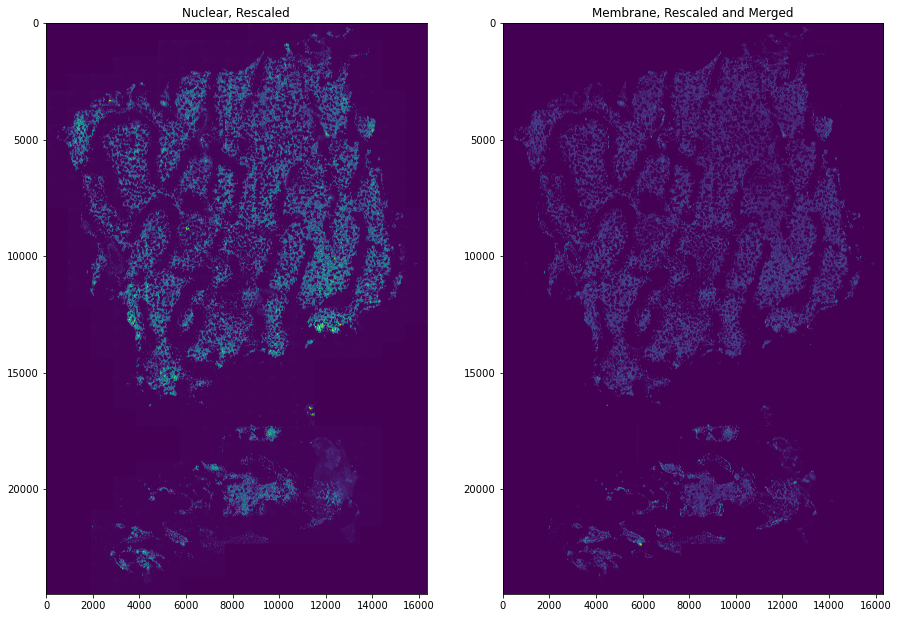

In [14]:
# Put nuclear and pan-membrane channels into a stack along axis=2
tif_for_mesmer = np.stack((nuclear_rescale_all, membrane_norm_all_merged_rescale), axis=2)

# Plot nuclear and pan-membrane stack
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(tif_for_mesmer[:,:,0])
ax[1].imshow(tif_for_mesmer[:,:,1])

ax[0].set_title('Nuclear, Rescaled')
ax[1].set_title('Membrane, Rescaled and Merged')

plt.show()

# Save resulting OME.TIFF as input to Mesmer/DeepCell

In [15]:
# Write nuclear and pan-membrane stack output as OME.TIF in the current directory
tifffile.imwrite(outFile, np.transpose(tif_for_mesmer, (2,0,1)).astype('uint16'))